In [1]:
!pip install librosa numpy pandas scikit-learn tensorflow keras


## 1- Unzipping the Dataset

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.



In [ ]:
!pip install pyzipper


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.0 MB/s eta 0:00:00


In [ ]:
import pyzipper

with pyzipper.AESZipFile('/content/drive/MyDrive/Colab Notebooks/archivexd.zip', mode='r') as zip_ref:
    zip_ref.extractall('/content/')


Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

## 2- Processing each audio file and making sure to extract the correct label

In [3]:
!pip install -U librosa resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.6 MB/s eta 0:00:00


In [4]:
!pip uninstall -y resampy
!pip install resampy


Found existing installation: resampy 0.4.3
Uninstalling resampy-0.4.3:
  Successfully uninstalled resampy-0.4.3
  Using cached resampy-0.4.3-py3-none-any.whl.metadata (3.0 kB)
Using cached resampy-0.4.3-py3-none-any.whl (3.1 MB)


In [ ]:
import librosa
import os
import numpy as np
import pandas as pd
import resampy

dataset_path = '/content/'

emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

features = []
labels = []

for actor in os.listdir(dataset_path):
    actor_folder = os.path.join(dataset_path, actor)

    if os.path.isdir(actor_folder) and actor.startswith("Actor"):
        for file in os.listdir(actor_folder):
            file_path = os.path.join(actor_folder, file)

            if file.endswith('.wav'):
                try:
                    emotion_code = file.split('-')[2]
                    emotion = emotion_labels.get(emotion_code, 'unknown')

                    if emotion != 'unknown':
                        features.append(extract_features(file_path))
                        labels.append(emotion)
                        print(f"Processed {file} with emotion {emotion}")
                    else:
                        print(f"Emotion code '{emotion_code}' in {file} is unknown and was skipped.")
                except IndexError:
                    print(f"Filename {file} does not follow the expected convention and was skipped.")
            else:
                print(f"Filename {file} does not follow the expected file format and was skipped.")

df = pd.DataFrame(features)
df['label'] = labels

print(df.head())
print(f"Total processed files: {len(df)}")


Processed 03-01-05-01-02-02-15.wav with emotion angry
Processed 03-01-03-01-01-02-15.wav with emotion happy
Processed 03-01-04-02-02-02-15.wav with emotion sad
Processed 03-01-08-01-01-01-15.wav with emotion surprised
Processed 03-01-02-02-02-02-15.wav with emotion calm
Processed 03-01-06-01-02-01-15.wav with emotion fearful
Processed 03-01-04-02-02-01-15.wav with emotion sad
Processed 03-01-03-02-01-01-15.wav with emotion happy
Processed 03-01-04-01-01-02-15.wav with emotion sad
Processed 03-01-07-01-01-02-15.wav with emotion disgust
Processed 03-01-06-02-01-02-15.wav with emotion fearful
Processed 03-01-08-02-01-01-15.wav with emotion surprised
Processed 03-01-07-02-01-01-15.wav with emotion disgust
Processed 03-01-01-01-02-01-15.wav with emotion neutral
Processed 03-01-05-01-02-01-15.wav with emotion angry
Processed 03-01-02-02-02-01-15.wav with emotion calm
Processed 03-01-03-01-02-02-15.wav with emotion happy
Processed 03-01-07-01-01-01-15.wav with emotion disgust
Processed 03-01-

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])

df['label'] = encoded_labels

X = df.drop(columns=['label'])
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (1008, 40), Validation set: (216, 40), Test set: (216, 40)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

features = np.array(features)
labels = np.array(labels)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

one_hot_labels = to_categorical(encoded_labels)

X_train, X_temp, y_train, y_temp = train_test_split(features, one_hot_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (1152, 40)
Validation set size: (144, 40)
Test set size: (144, 40)


## 3- Model Training

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, input_shape=(40,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.1609 - loss: 39.0100 - val_accuracy: 0.1528 - val_loss: 4.7761
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1676 - loss: 3.4881 - val_accuracy: 0.2361 - val_loss: 2.3910
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2558 - loss: 2.2989 - val_accuracy: 0.2500 - val_loss: 2.3474
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2498 - loss: 2.3513 - val_accuracy: 0.2153 - val_loss: 2.3752
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2475 - loss: 2.4941 - val_accuracy: 0.2639 - val_loss: 2.0912
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3078 - loss: 2.0717 - val_accuracy: 0.2917 - val_loss: 1.9862
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3092 - loss: 1.9880 - val_accuracy: 0.3194 - val_loss: 1.9455
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3407 - loss: 1.8155 - val_accuracy: 0.3472 -

### 3.1- Increase complexitiy of the model + Increase Epochs Number to 100

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, activation='relu', input_shape=(40,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1202 - loss: 12.2559 - val_accuracy: 0.1806 - val_loss: 2.7320
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1750 - loss: 2.4224 - val_accuracy: 0.1875 - val_loss: 2.1886
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2352 - loss: 2.1393 - val_accuracy: 0.2569 - val_loss: 2.0194
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2696 - loss: 2.0335 - val_accuracy: 0.1944 - val_loss: 2.0717
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2762 - loss: 2.0283 - val_accuracy: 0.2083 - val_loss: 2.0579
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2717 - loss: 2.0931 - val_accuracy: 0.2500 - val_loss: 1.9608
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2748 - loss: 1.9116 - val_accuracy: 0.2639 - val_loss: 1.9137
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3386 - loss: 1.7625 - val_accuracy: 0.2292 - 

### 3.2- Use lower learning rate 0.001 to 0.0001

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, activation='relu', input_shape=(40,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0901 - loss: 5.6463 - val_accuracy: 0.1806 - val_loss: 2.7041
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1739 - loss: 2.5603 - val_accuracy: 0.1597 - val_loss: 2.4937
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2117 - loss: 2.3063 - val_accuracy: 0.1806 - val_loss: 2.3037
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1911 - loss: 2.2534 - val_accuracy: 0.1944 - val_loss: 2.1149
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2334 - loss: 2.1293 - val_accuracy: 0.2431 - val_loss: 2.1072
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2397 - loss: 2.1098 - val_accuracy: 0.2222 - val_loss: 2.1062
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2564 - loss: 2.0541 - val_accuracy: 0.2708 - val_loss: 2.0199
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2589 - loss: 1.9619 - val_accuracy: 0.2639 - 

### 3.3 Go back to the starting learning rate and add drop out layers


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout


model = Sequential([
    Dense(256, activation='relu', input_shape=(40,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1263 - loss: 47.0563 - val_accuracy: 0.1528 - val_loss: 3.2855
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1084 - loss: 14.0109 - val_accuracy: 0.1389 - val_loss: 2.3359
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1230 - loss: 5.9769 - val_accuracy: 0.1597 - val_loss: 2.0645
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1061 - loss: 3.8493 - val_accuracy: 0.1389 - val_loss: 2.0750
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1277 - loss: 2.5590 - val_accuracy: 0.1389 - val_loss: 2.0736
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1401 - loss: 2.3839 - val_accuracy: 0.1389 - val_loss: 2.0719
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1306 - loss: 2.2711 - val_accuracy: 0.1389 - val_loss: 2.0706
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1225 - loss: 2.2008 - val_accuracy: 0.1389 -

#### 3.4- Remove the dropout layers and try batch normalization

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(256, activation='relu', input_shape=(40,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 8)

# Thursday, 2024

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])

df['label'] = encoded_labels

X = df.drop(columns=['label'])
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (1008, 40), Validation set: (216, 40), Test set: (216, 40)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import LSTM

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(64, return_sequences=False),  # Add an LSTM layer
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,888 (292.53 KB)

 Trainable params: 74,888 (292.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(
    X_train_reshaped, y_train,             # Training data
    epochs=100,                            # Number of epochs (adjustable based on performance)
    batch_size=32,                         # Batch size
    validation_data=(X_val_reshaped, y_val),  # Validation data
    verbose=1                              # Display training progress
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8989 - loss: 0.3666 - val_accuracy: 0.5509 - val_loss: 1.5401
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8791 - loss: 0.3542 - val_accuracy: 0.5463 - val_loss: 1.5019
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8759 - loss: 0.3565 - val_accuracy: 0.5093 - val_loss: 1.6003
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8763 - loss: 0.3675 - val_accuracy: 0.5278 - val_loss: 1.6121
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8748 - loss: 0.3575 - val_accuracy: 0.5787 - val_loss: 1.5362
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9040 - loss: 0.3159 - val_accuracy: 0.5833 - val_loss: 1.5217
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9070 - loss: 0.3285 - val_accuracy: 0.5694 - val_loss: 1.6066
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8856 - loss: 0.3564 - val_accuracy: 0.

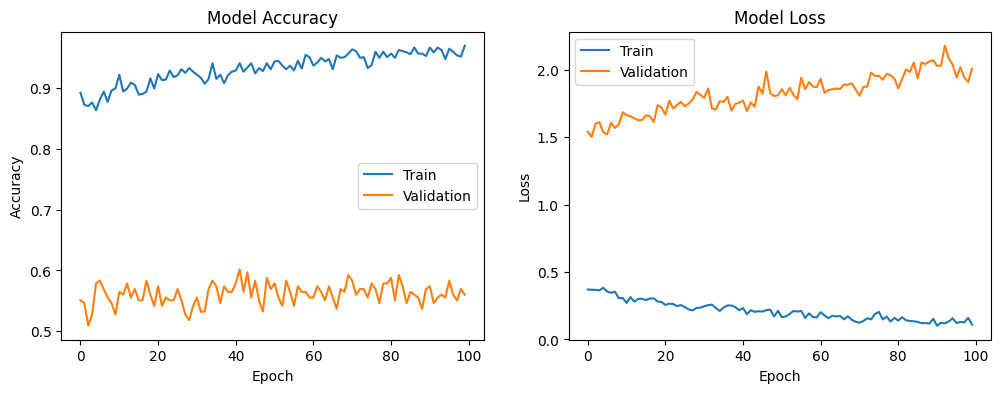

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


-----------
-------------
-------------
-------------

# Sunday, 2024

# 1- Apply Data Augmentation




In [ ]:
import librosa
import numpy as np

def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def pitch_shift(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

def time_stretch(data, rate=1.1):
    return librosa.effects.time_stretch(data, rate=rate)

def shift_audio(data, shift_max=0.2):
    shift = int(len(data) * shift_max)
    return np.roll(data, shift)


# 2- Feature Extraction (ZCR/RMSE/MFCC)

In [ ]:
def zcr(data):
    return np.squeeze(librosa.feature.zero_crossing_rate(data))

def rmse(data):
    return np.squeeze(librosa.feature.rms(y=data))

def mfcc(data, sr=22050, n_mfcc=40):
    return np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc).T, axis=0)

def extract_features(data, sr=22050):
    return np.hstack([zcr(data), rmse(data), mfcc(data, sr)])


# 3- Saving features and labels as a CSV
Convenience: It allows you to load the preprocessed data directly without rerunning the feature extraction and augmentation steps, which can save time.

Portability: You can easily transfer or share the dataset as a single file.

Reusability: Storing the data in a CSV allows you to explore and experiment with different models without needing to extract features each time.

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

dataset_path = '/content/'
emotion_labels = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

X, Y = [], []

def get_features(file_path, sr=22050, duration=2.0):
    data, _ = librosa.load(file_path, sr=sr, duration=duration)
    data = librosa.util.fix_length(data, size=int(sr * duration))

    features = [extract_features(data, sr)]

    for aug_func in [add_noise, lambda x: pitch_shift(x, sr), lambda x: time_stretch(x), shift_audio]:
        augmented_data = aug_func(data)
        augmented_data = librosa.util.fix_length(augmented_data, size=int(sr * duration))

        features.append(extract_features(augmented_data, sr))

    return np.vstack(features)


for actor in os.listdir(dataset_path):
    actor_folder = os.path.join(dataset_path, actor)
    if os.path.isdir(actor_folder) and actor.startswith("Actor"):
        for file in os.listdir(actor_folder):
            file_path = os.path.join(actor_folder, file)
            if file.endswith('.wav'):
                emotion_code = file.split('-')[2]
                emotion = emotion_labels.get(emotion_code, 'unknown')
                if emotion != 'unknown':
                    features = get_features(file_path)
                    for feature in features:
                        X.append(feature)
                        Y.append(emotion)

df = pd.DataFrame(X)
df['Emotion'] = Y
df.to_csv('emotion_features.csv', index=False)


# 4- Load Features and Prepare Data for CNN
With the features saved, load them into a new DataFrame and prepare the data for CNN training. Here, we’ll one-hot encode labels and split the data for training and testing.




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 5- Train CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1797 - loss: 2.4386 - val_accuracy: 0.1875 - val_loss: 2.0250
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2365 - loss: 1.9128 - val_accuracy: 0.1903 - val_loss: 2.0027
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2477 - loss: 1.8947 - val_accuracy: 0.1868 - val_loss: 1.9387
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2567 - loss: 1.8536 - val_accuracy: 0.2035 - val_loss: 2.0158
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2814 - loss: 1.8280 - val_accuracy: 0.1569 - val_loss: 2.2749
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2889 - loss: 1.7959 - val_accuracy: 0.1611 - val_loss: 2.5930
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2865 - loss: 1.7992 - val_accuracy: 0.1500 - val_loss: 2.8986
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3061 - loss: 1.7750 - val_accuracy: 0.1729 - 

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4466 - loss: 1.5145
Test accuracy: 0.44930556416511536


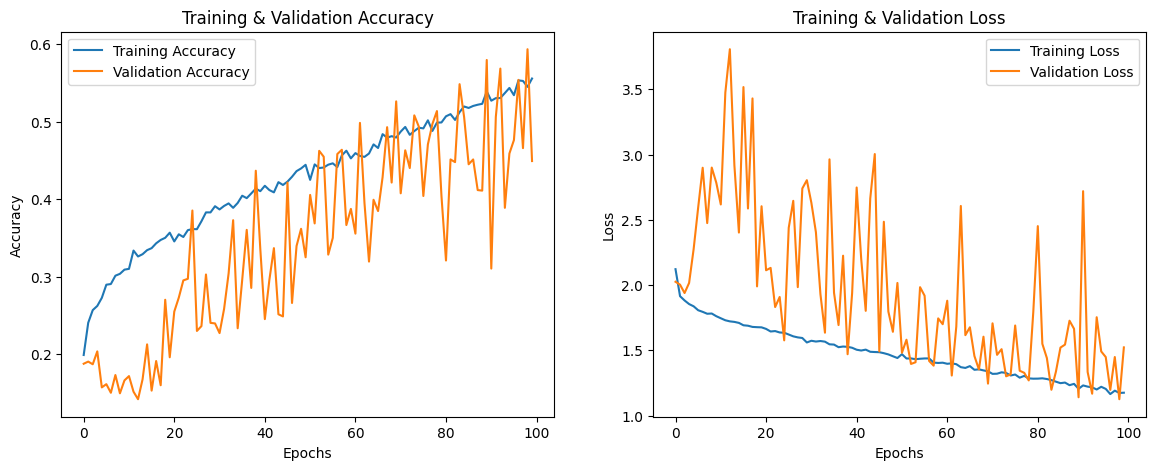

In [ ]:
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_accuracy)

epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


Fluctuating Validation accuracy

# 5.1 Increase regularization (Dropout)
dropout rates to 0.4 in some layers and 0.5 in the dense layer at the end for stronger regularization.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1)


GPU memory growth enabled.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1472 - loss: 2.7108 - val_accuracy: 0.1764 - val_loss: 2.0399
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1940 - loss: 1.9972 - val_accuracy: 0.2229 - val_loss: 1.9816
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2073 - loss: 1.9671 - val_accuracy: 0.1528 - val_loss: 1.9784
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2333 - loss: 1.9250 - val_accuracy: 0.1833 - val_loss: 1.9462
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2249 - loss: 1.9231 - val_accuracy: 0.2118 - val_loss: 1.9307
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2481 - loss: 1.8894 - val_accuracy: 0.1410 - val_loss: 2.2392
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2509 - loss: 1.8736 - val_accuracy: 0.1472 - val_loss: 2.4281
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2501 - loss: 1.8783 - val_accuracy: 0.2007 - 

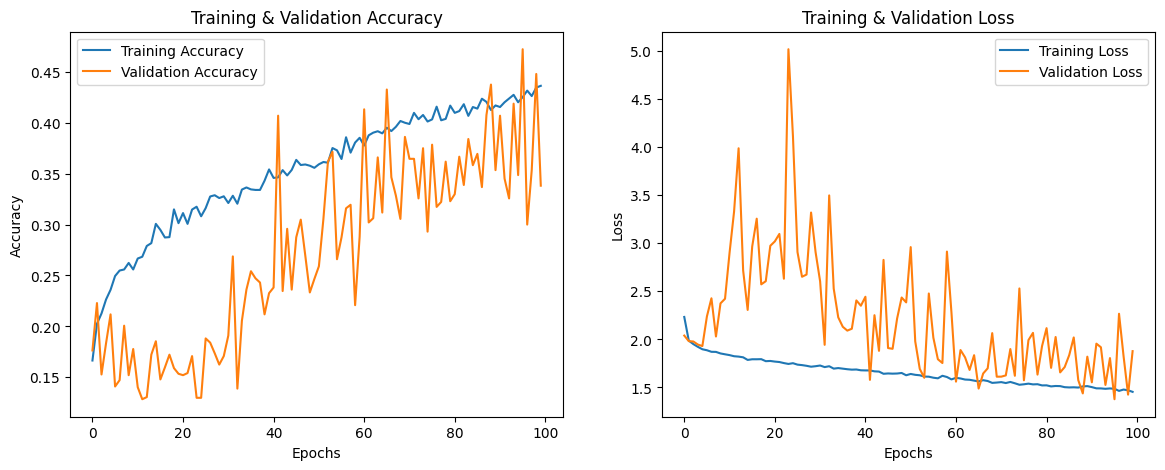

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


# 5.2- Increase data augmentation techniques

In [ ]:
import librosa
import numpy as np


def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def add_multiple_noise(data):
    return [add_noise(data, noise_factor) for noise_factor in [0.003, 0.005, 0.008]]

def pitch_shift(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def apply_pitch_shifts(data, sr):
    return [pitch_shift(data, sr, n_steps) for n_steps in [-2, -1, 1, 2, 3]]

def time_stretch(data, rate=1.1):
    return librosa.effects.time_stretch(y=data, rate=rate)

def apply_time_stretching(data):
    return [time_stretch(data, rate) for rate in [0.8, 1.0, 1.1, 1.2]]

def speed_variation(data, rate=1.1):
    return librosa.effects.time_stretch(y=data, rate=rate)

def apply_speed_variation(data):
    return [speed_variation(data, rate) for rate in [0.9, 1.0, 1.1]]


In [ ]:
def zcr(data):
    return np.squeeze(librosa.feature.zero_crossing_rate(data))

def rmse(data):
    return np.squeeze(librosa.feature.rms(y=data))

def mfcc(data, sr=22050, n_mfcc=40):
    return np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc).T, axis=0)

def extract_features(data, sr=22050):
    return np.hstack([zcr(data), rmse(data), mfcc(data, sr)])


In [ ]:
import os
import pandas as pd
from tqdm import tqdm

dataset_path = '/content/'
emotion_labels = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

X, Y = [], []

def get_features(file_path, sr=22050, duration=2.0):
    data, _ = librosa.load(file_path, sr=sr, duration=duration)
    data = librosa.util.fix_length(data, size=int(sr * duration))

    features = [extract_features(data, sr)]

    for aug_data in add_multiple_noise(data):
        aug_data = librosa.util.fix_length(aug_data, size=int(sr * duration))
        features.append(extract_features(aug_data, sr))

    for aug_data in apply_pitch_shifts(data, sr):
        aug_data = librosa.util.fix_length(aug_data, size=int(sr * duration))
        features.append(extract_features(aug_data, sr))

    for aug_data in apply_time_stretching(data):
        aug_data = librosa.util.fix_length(aug_data, size=int(sr * duration))
        features.append(extract_features(aug_data, sr))

    for aug_data in apply_speed_variation(data):
        aug_data = librosa.util.fix_length(aug_data, size=int(sr * duration))
        features.append(extract_features(aug_data, sr))

    return np.vstack(features)



for actor in os.listdir(dataset_path):
    actor_folder = os.path.join(dataset_path, actor)
    if os.path.isdir(actor_folder) and actor.startswith("Actor"):
        for file in os.listdir(actor_folder):
            file_path = os.path.join(actor_folder, file)
            if file.endswith('.wav'):
                emotion_code = file.split('-')[2]
                emotion = emotion_labels.get(emotion_code, 'unknown')
                if emotion != 'unknown':
                    features = get_features(file_path)
                    for feature in features:
                        X.append(feature)
                        Y.append(emotion)

df = pd.DataFrame(X)
df['Emotion'] = Y
df.to_csv('emotion_features.csv', index=False)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1969 - loss: 2.2021 - val_accuracy: 0.1719 - val_loss: 2.1304
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2910 - loss: 1.8124 - val_accuracy: 0.1708 - val_loss: 2.8985
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3110 - loss: 1.7729 - val_accuracy: 0.1997 - val_loss: 2.4474
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3321 - loss: 1.7353 - val_accuracy: 0.2025 - val_loss: 2.4793
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3179 - loss: 1.7223 - val_accuracy: 0.1892 - val_loss: 2.6455
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3367 - loss: 1.6972 - val_accuracy: 0.1868 - val_loss: 2.9843
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3548 - loss: 1.6646 - val_accuracy: 0.2630 - val_loss: 2.2306
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3573 - loss: 1.6582 - val_accu

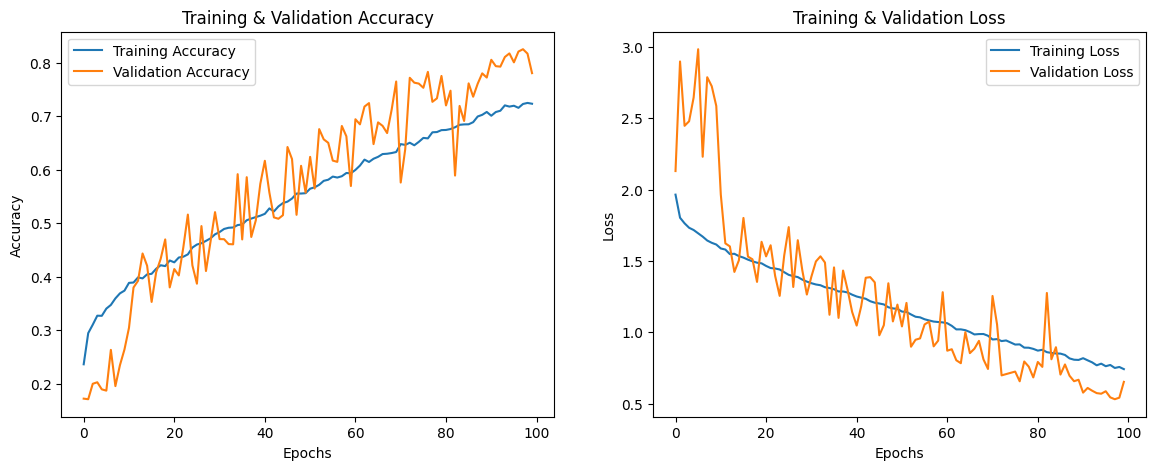

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


# 5.3- Increase epochs number from 100 to 200

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1867 - loss: 2.2413 - val_accuracy: 0.2248 - val_loss: 1.9254
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2546 - loss: 1.8673 - val_accuracy: 0.2320 - val_loss: 1.9058
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2940 - loss: 1.7977 - val_accuracy: 0.2159 - val_loss: 2.2088
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3057 - loss: 1.7676 - val_accuracy: 0.2808 - val_loss: 1.8520
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3231 - loss: 1.7490 - val_accuracy: 0.1875 - val_loss: 2.5861
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3330 - loss: 1.7162 - val_accuracy: 0.2300 - val_loss: 2.1961
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3400 - loss: 1.6922 - val_accuracy: 0.2129 - val_loss: 2.4430
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3445 - loss: 1.6830 - val_accu

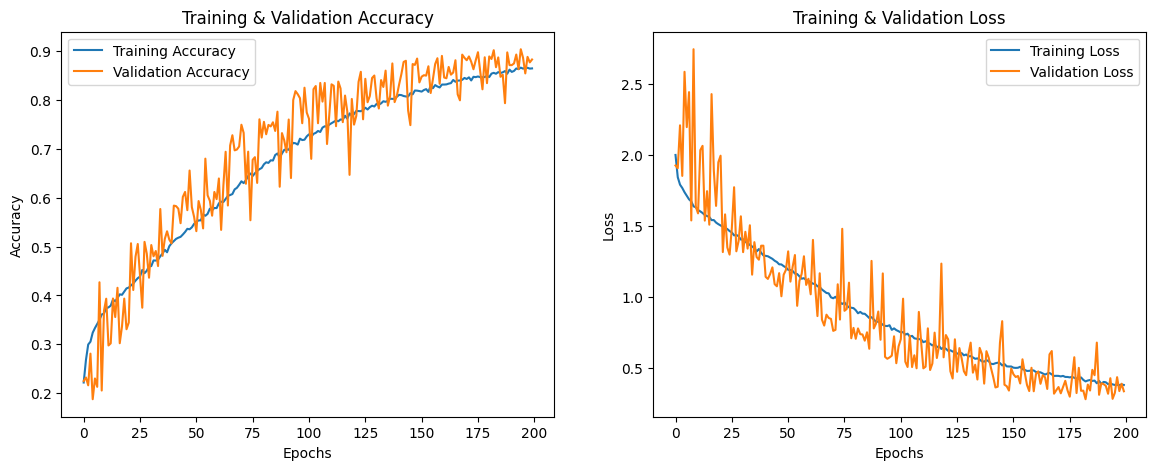

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


# 5.4- Increase dropout (0.4 Conv | 0.5 Dense)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1722 - loss: 2.2045 - val_accuracy: 0.1723 - val_loss: 2.0745
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2468 - loss: 1.8920 - val_accuracy: 0.1469 - val_loss: 2.0897
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2636 - loss: 1.8565 - val_accuracy: 0.1777 - val_loss: 2.3838
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2834 - loss: 1.8193 - val_accuracy: 0.1814 - val_loss: 2.4036
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2929 - loss: 1.7952 - val_accuracy: 0.1695 - val_loss: 2.6728
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2900 - loss: 1.7886 - val_accuracy: 0.1756 - val_loss: 2.8818
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3028 - loss: 1.7759 - val_accuracy: 0.1536 - val_loss: 2.7971
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3058 - loss: 1.7786 - val_accu

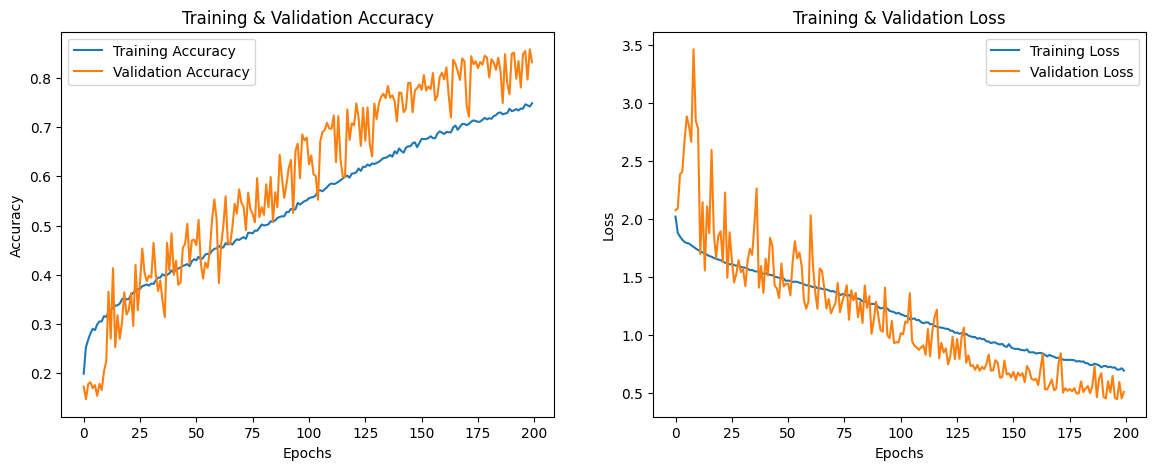

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


# 5.5- 0.35 conv 0.45 dense


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.35),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.35),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.35),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.45),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1744 - loss: 2.2744 - val_accuracy: 0.1964 - val_loss: 1.9880
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2365 - loss: 1.8899 - val_accuracy: 0.2033 - val_loss: 2.1062
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2689 - loss: 1.8457 - val_accuracy: 0.2122 - val_loss: 2.0733
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2825 - loss: 1.8197 - val_accuracy: 0.2070 - val_loss: 2.2800
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2864 - loss: 1.7922 - val_accuracy: 0.1777 - val_loss: 2.9495
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3103 - loss: 1.7649 - val_accuracy: 0.1682 - val_loss: 3.4347
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3111 - loss: 1.7597 - val_accuracy: 0.2357 - val_loss: 2.2894
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3202 - loss: 1.7362 - val_accu

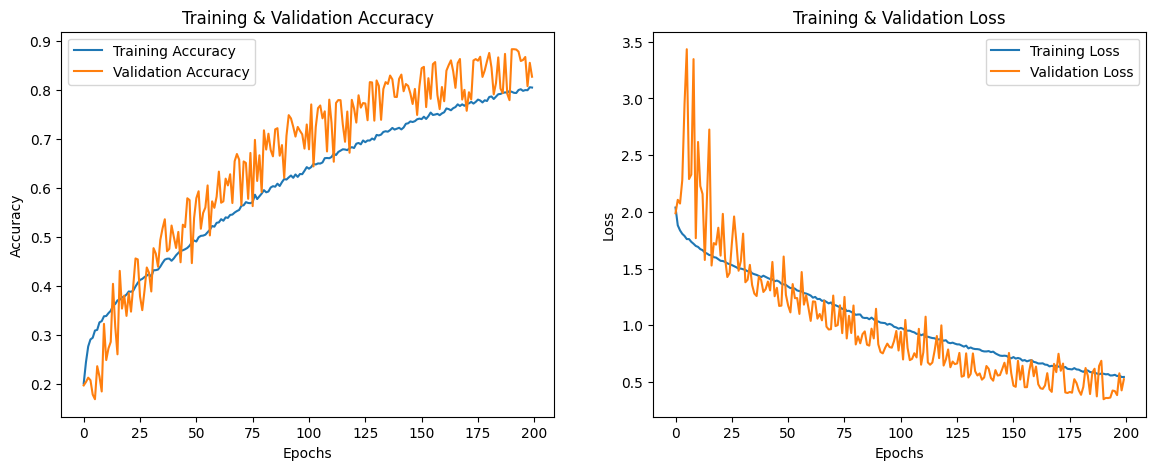

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


# 5.6- Decrease the dropout (0.25 conv 0.35 dense)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.25),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.25),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.35),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1908 - loss: 2.2048 - val_accuracy: 0.2565 - val_loss: 1.8755
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2919 - loss: 1.8089 - val_accuracy: 0.2164 - val_loss: 2.0278
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3175 - loss: 1.7551 - val_accuracy: 0.2179 - val_loss: 2.3152
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3338 - loss: 1.7097 - val_accuracy: 0.1571 - val_loss: 3.0160
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3441 - loss: 1.6817 - val_accuracy: 0.2598 - val_loss: 2.1141
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3702 - loss: 1.6308 - val_accuracy: 0.1558 - val_loss: 4.2772
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3740 - loss: 1.6191 - val_accuracy: 0.3290 - val_loss: 1.9073
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3923 - loss: 1.5829 - val_accu

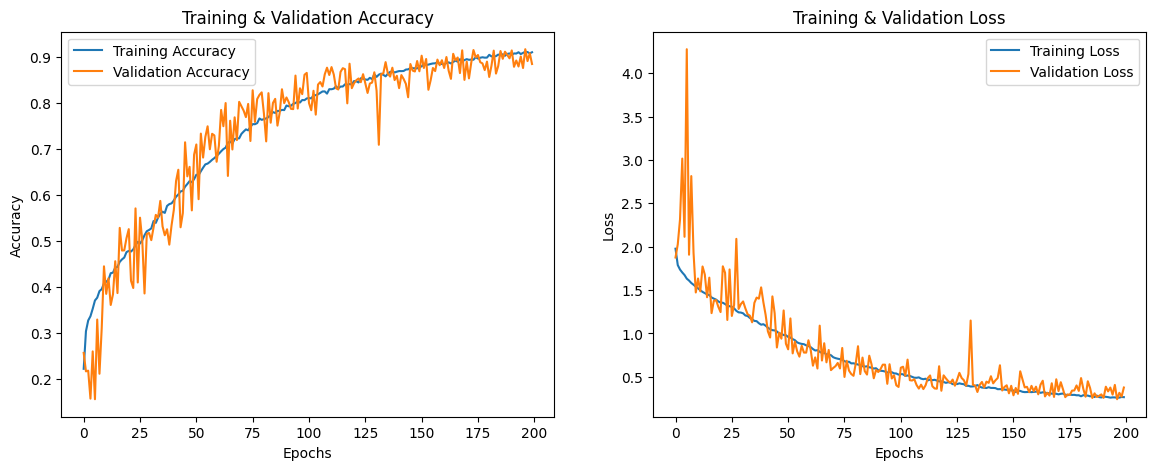

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


This is so far the best Model.

# 5.7 Decrese dropout further (0.20 conv | 0.30 dense)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.20),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.20),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.20),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.30),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_28 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2006 - loss: 2.3101 - val_accuracy: 0.2194 - val_loss: 1.9281
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3153 - loss: 1.7633 - val_accuracy: 0.1994 - val_loss: 2.2778
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3404 - loss: 1.6997 - val_accuracy: 0.2151 - val_loss: 2.2318
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3674 - loss: 1.6415 - val_accuracy: 0.2294 - val_loss: 2.4934
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3799 - loss: 1.6054 - val_accuracy: 0.3105 - val_loss: 1.8296
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3856 - loss: 1.5908 - val_accuracy: 0.3045 - val_loss: 1.9122
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4044 - loss: 1.5341 - val_accuracy: 0.2112 - val_loss: 2.6926
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4083 - loss: 1.5175 - val_accu

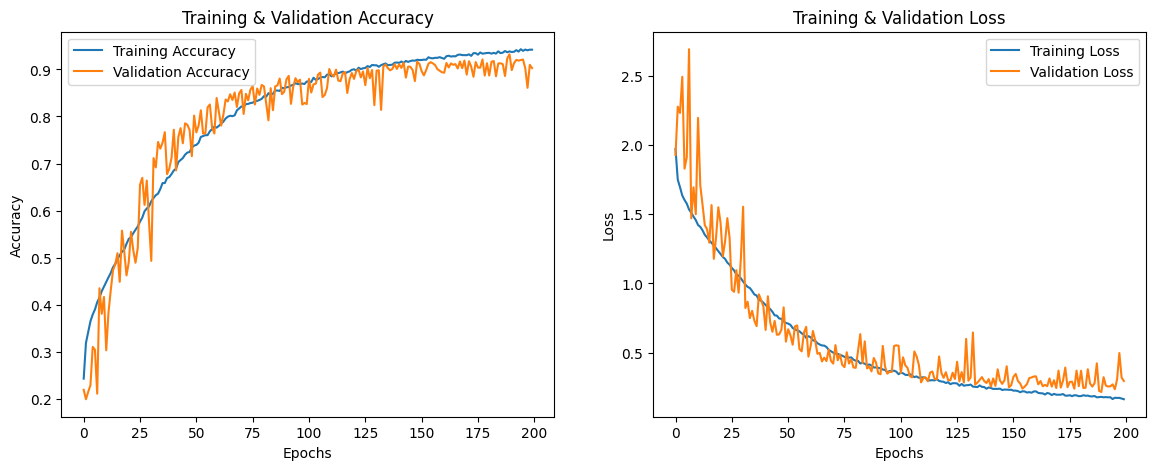

In [ ]:
# Plot accuracy and loss curves
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


Again, this one is the best so far.

# 5.8- Decrese further (0.15 conv | 0.25 dense)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.15),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.15),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.15),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_32 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2116 - loss: 2.2716 - val_accuracy: 0.2272 - val_loss: 2.0013
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3191 - loss: 1.7468 - val_accuracy: 0.2368 - val_loss: 2.0934
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3531 - loss: 1.6621 - val_accuracy: 0.2383 - val_loss: 2.2602
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3865 - loss: 1.6013 - val_accuracy: 0.3008 - val_loss: 1.9101
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4029 - loss: 1.5579 - val_accuracy: 0.2921 - val_loss: 1.8764
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4178 - loss: 1.5047 - val_accuracy: 0.1975 - val_loss: 3.1087
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4335 - loss: 1.4713 - val_accuracy: 0.2786 - val_loss: 2.2958
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4503 - loss: 1.4317 - val_accu

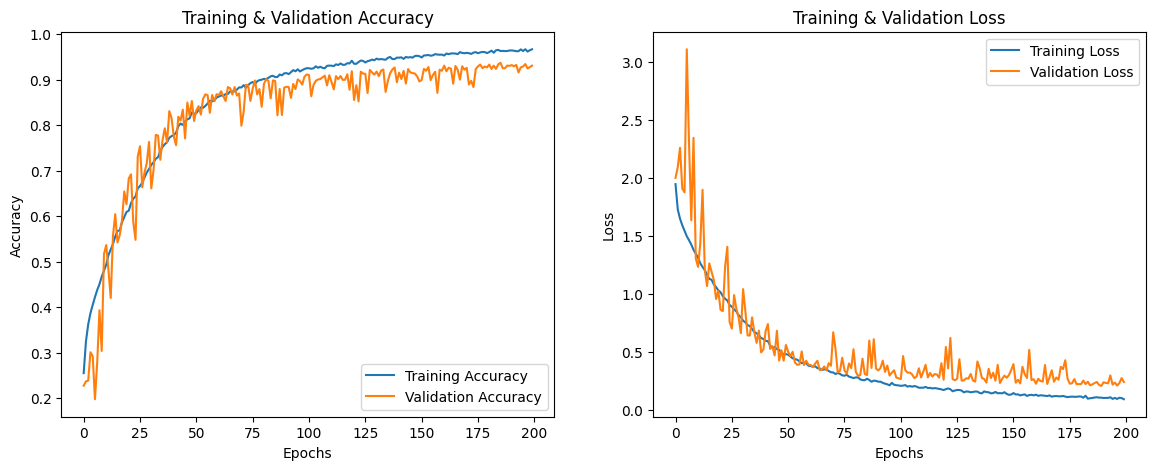

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


### Best Model
It achieves higher validation accuracy and lower validation loss. This suggests that Model generalizes better to new, unseen data, which is typically the more important measure for evaluating model performance.

# 5.9- Decrese further (0.10 conv | 0.20 dense)

In [5]:
import librosa
import os
import numpy as np
import pandas as pd
import resampy

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.10),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.10),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.10),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.20),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_34 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2407 - loss: 2.2981 - val_accuracy: 0.3025 - val_loss: 1.7777
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3434 - loss: 1.6862 - val_accuracy: 0.3505 - val_loss: 1.6874
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3699 - loss: 1.6268 - val_accuracy: 0.2949 - val_loss: 1.9822
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4069 - loss: 1.5434 - val_accuracy: 0.2943 - val_loss: 2.0797
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4325 - loss: 1.4653 - val_accuracy: 0.2808 - val_loss: 2.3746
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4545 - loss: 1.3970 - val_accuracy: 0.2943 - val_loss: 2.5472
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4813 - loss: 1.3552 - val_accuracy: 0.4230 - val_loss: 1.6678
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5040 - loss: 1.3065 - val_accu

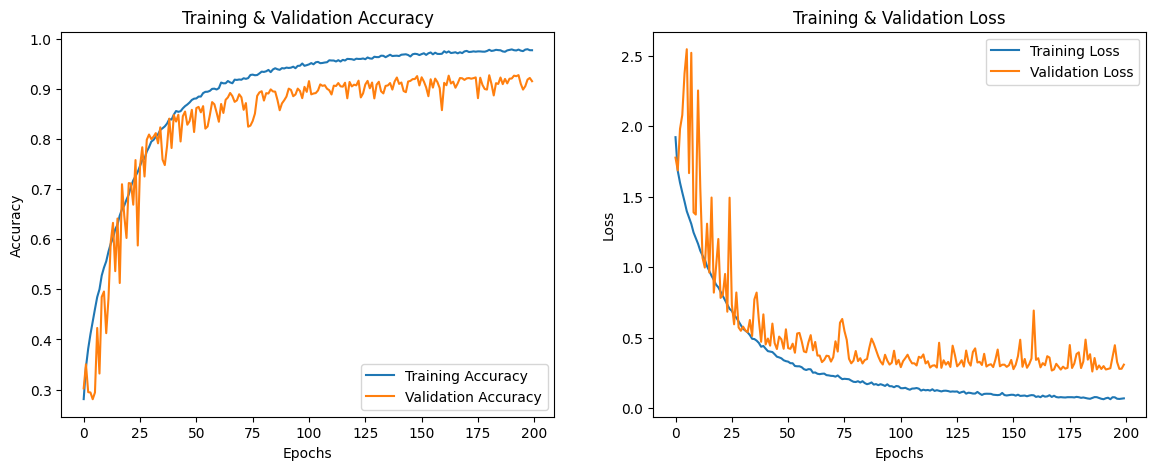

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


# 5.10- Decrese further (Last Test) (0.5 conv | 0.15 dense)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.15),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_37 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_38 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_38 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1944 - loss: 2.2642 - val_accuracy: 0.1369 - val_loss: 2.1678
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2763 - loss: 1.8491 - val_accuracy: 0.1393 - val_loss: 2.6159
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2996 - loss: 1.7933 - val_accuracy: 0.1491 - val_loss: 2.7722
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3159 - loss: 1.7610 - val_accuracy: 0.1382 - val_loss: 3.4547
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3255 - loss: 1.7348 - val_accuracy: 0.1556 - val_loss: 3.2319
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3376 - loss: 1.7135 - val_accuracy: 0.1953 - val_loss: 2.5265
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3437 - loss: 1.7030 - val_accuracy: 0.1443 - val_loss: 3.7775
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3483 - loss: 1.6904 - val_accu

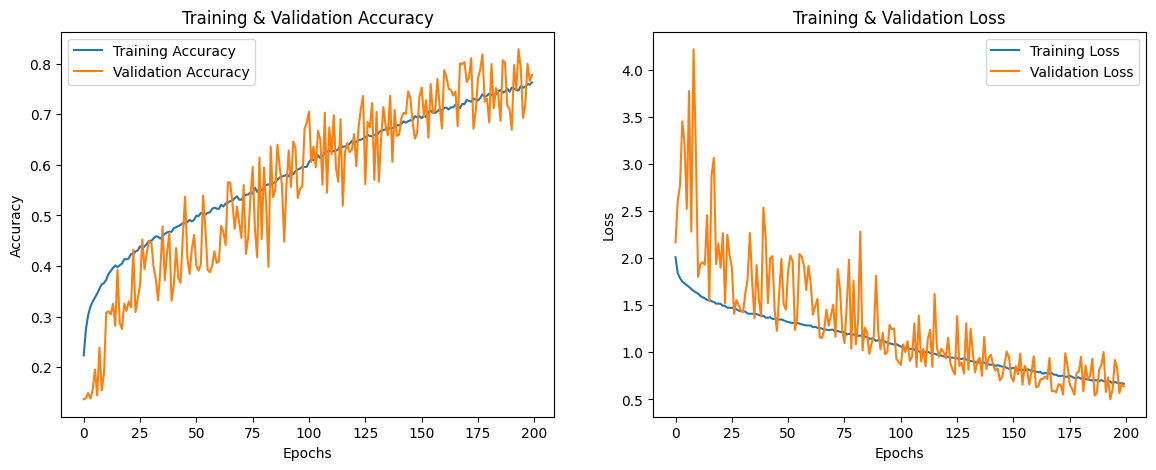

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


This is so bad.

# 6- Proceed with test on the best model (0.15 conv | 0.25 dense)

# 15% for Test and Vaildation (85% Training)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.075, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.0811, random_state=42, stratify=Y_train_val)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 19583
Validation set size: 1729
Test set size: 1728


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.15),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.15),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.15),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(Y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val, Y_val))


GPU memory growth enabled.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)                   │ (None, 212, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_54 (MaxPooling1D)      │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 106, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 106, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 104, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_55 (MaxPooling1D)      │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 52, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 52, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_56 (Conv1D)                   │ (None, 50, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_56 (MaxPooling1D)      │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 25, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,766,024 (6.74 MB)

 Trainable params: 1,765,128 (6.73 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.3379 - loss: 1.9298 - val_accuracy: 0.3621 - val_loss: 1.6419
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5150 - loss: 1.2772 - val_accuracy: 0.6316 - val_loss: 0.9974
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6123 - loss: 1.0200 - val_accuracy: 0.7224 - val_loss: 0.7617
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6933 - loss: 0.8165 - val_accuracy: 0.7669 - val_loss: 0.6140
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7484 - loss: 0.6755 - val_accuracy: 0.8132 - val_loss: 0.5200
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7867 - loss: 0.5761 - val_accuracy: 0.8346 - val_loss: 0.4410
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8248 - loss: 0.4794 - val_accuracy: 0.8658 - val_loss: 0.3729
Epoch 8/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8512 - loss: 0.4079 - val_ac

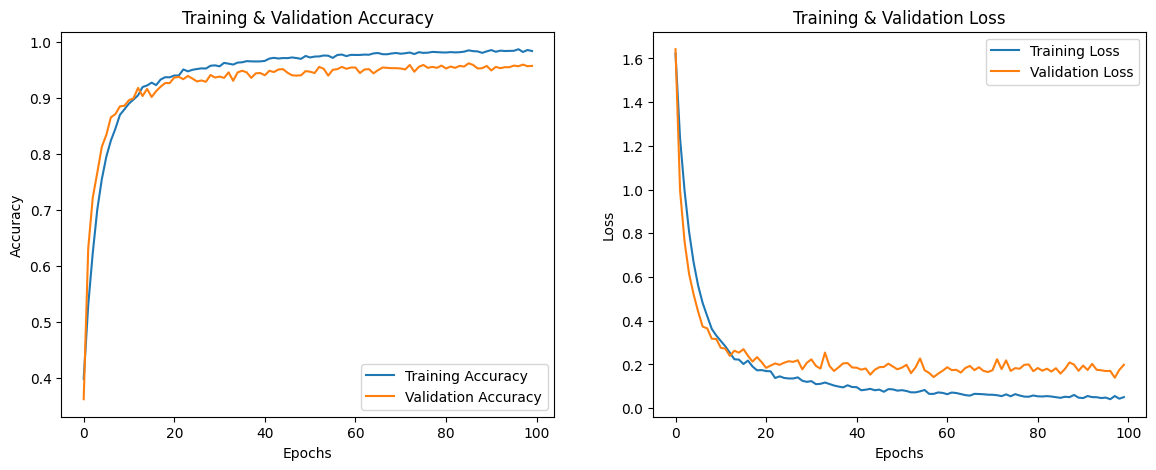

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9322 - loss: 0.3153
Test Loss: 0.2559067904949188
Test Accuracy: 0.9403935074806213
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.98      0.97      0.97       231
        calm       0.94      0.90      0.92       230
     disgust       0.97      0.96      0.96       231
     fearful       0.90      0.94      0.92       231
       happy       0.98      0.91      0.94       230
     neutral       0.93      0.92      0.93       115
         sad       0.90      0.94      0.92       230
   surprised       0.93      0.98      0.95       230

    accuracy                           0.94      1728
   macro avg       0.94      0.94      0.94      1728
weighted avg       0.94      0.94      0.94      1728



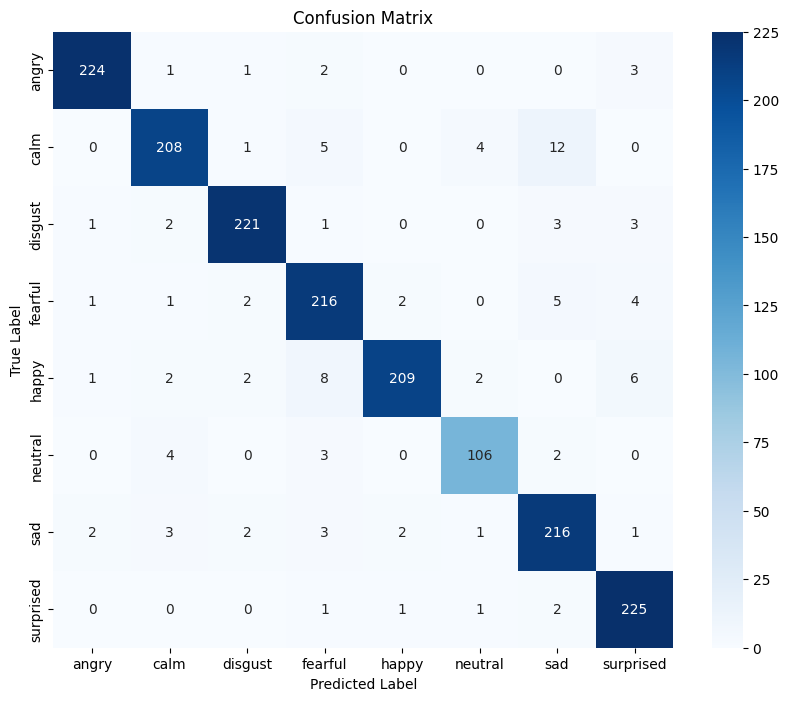

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Y_pred = model.predict(X_test)
Y_pred_classes = Y_pred.argmax(axis=1)
Y_true = Y_test.argmax(axis=1)

print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=encoder.categories_[0]))

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save("speech_emotion_recognition_model.keras")
print("Model saved as 'speech_emotion_recognition_model.keras'")


Model saved as 'speech_emotion_recognition_model.keras'


----------
--------
------
------
------
------
------

# LSTM Model

## 1- Prepare Data for LSTM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.15, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2- Defining LSTM Model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.15),
    BatchNormalization(),

    LSTM(128, return_sequences=True),
    Dropout(0.15),
    BatchNormalization(),

    LSTM(128),
    Dropout(0.15),
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(Y_train.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

checkpoint = ModelCheckpoint("best_lstm_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")


history = lstm_model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint]
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 214, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 214, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 214, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 214, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 214, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 214, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,344 (1.40 MB)

 Trainable params: 365,576 (1.39 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.2102 - loss: 2.0687 - val_accuracy: 0.2743 - val_loss: 1.8557
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.2839 - loss: 1.8548 - val_accuracy: 0.2905 - val_loss: 1.8638
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.3562 - loss: 1.6693 - val_accuracy: 0.3773 - val_loss: 1.6473
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4122 - loss: 1.5477 - val_accuracy: 0.4560 - val_loss: 1.4617
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4554 - loss: 1.4367 - val_accuracy: 0.4387 - val_loss: 1.4589
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4836 - loss: 1.3637 - val_accuracy: 0.4763 - val_loss: 1.3912
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5132 - loss: 1.2848 - val_accuracy: 0.4884 - val_loss: 1.3546
Epoch 8/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5575 - loss: 1

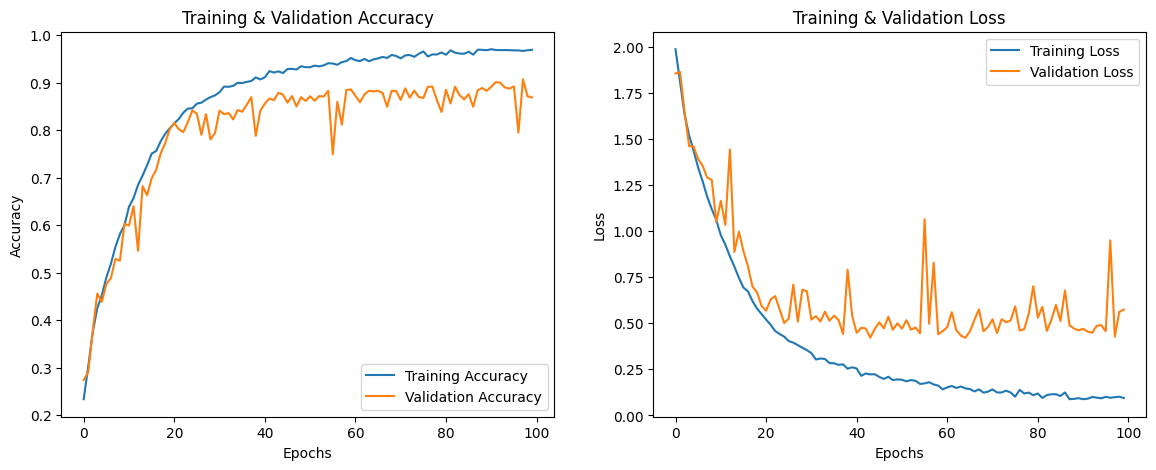

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.models import load_model

lstm_model = load_model("best_lstm_model.keras")

test_loss, test_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=1)
print(f"LSTM Test Loss: {test_loss}")
print(f"LSTM Test Accuracy: {test_accuracy}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8918 - loss: 0.4679
LSTM Test Loss: 0.5071310997009277
LSTM Test Accuracy: 0.8825231194496155


## 2.1 Test with more LSTM Units (128 - 256)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.15, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

lstm_model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.15),
    BatchNormalization(),

    LSTM(256, return_sequences=True),
    Dropout(0.15),
    BatchNormalization(),

    LSTM(256),
    Dropout(0.15),
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(Y_train.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

checkpoint = ModelCheckpoint("best_lstm_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")


history = lstm_model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint]
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 214, 256)            │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 214, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 214, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 214, 256)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 214, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_61               │ (None, 214, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_62               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,385,736 (5.29 MB)

 Trainable params: 1,384,200 (5.28 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.1984 - loss: 2.1933 - val_accuracy: 0.2500 - val_loss: 1.9074
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.2716 - loss: 1.8948 - val_accuracy: 0.2373 - val_loss: 2.0052
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.3183 - loss: 1.7807 - val_accuracy: 0.3374 - val_loss: 1.7320
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.3666 - loss: 1.6514 - val_accuracy: 0.3900 - val_loss: 1.5716
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.3952 - loss: 1.5849 - val_accuracy: 0.4213 - val_loss: 1.5192
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4417 - loss: 1.4739 - val_accuracy: 0.4201 - val_loss: 1.4628
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4722 - loss: 1.4011 - val_accuracy: 0.4838 - val_loss: 1.3662
Epoch 8/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4984 - loss: 1

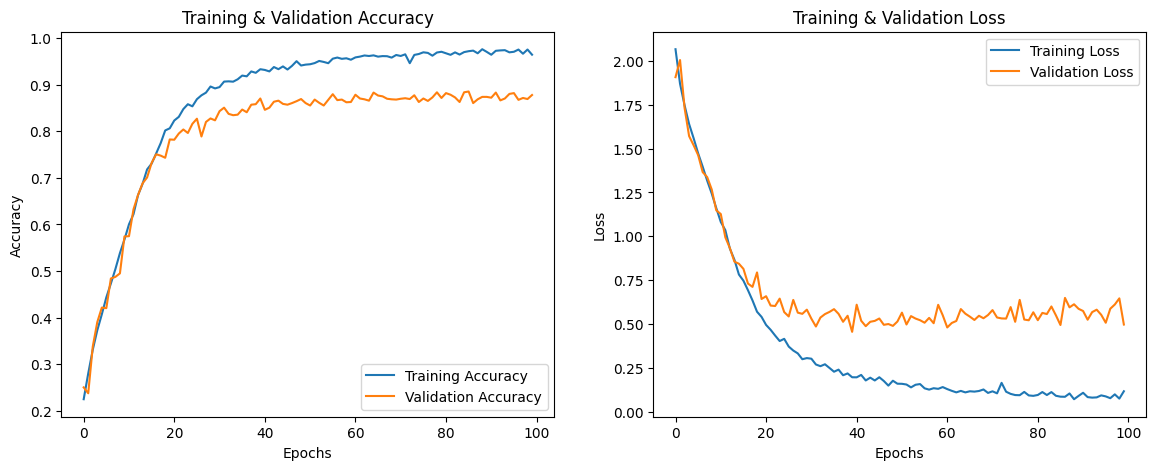

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.models import load_model

lstm_model = load_model("best_lstm_model.keras")

test_loss, test_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=1)
print(f"LSTM Test Loss: {test_loss}")
print(f"LSTM Test Accuracy: {test_accuracy}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8757 - loss: 0.4908
LSTM Test Loss: 0.5108563899993896
LSTM Test Accuracy: 0.8744212985038757


Previous steup was better.

## 2.2- Increase the epochs + decrease the dropout further (0.10 | 0.20) + Revert the previous units except the last one.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.15, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.10),
    BatchNormalization(),

    LSTM(128, return_sequences=True),
    Dropout(0.10),
    BatchNormalization(),

    LSTM(128),
    Dropout(0.10),
    BatchNormalization(),

    Dense(256, activation='relu'),
    Dropout(0.20),
    Dense(Y_train.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

checkpoint = ModelCheckpoint("best_lstm_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")


history = lstm_model.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint]
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 214, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 214, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 214, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 214, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 214, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 214, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,344 (1.40 MB)

 Trainable params: 365,576 (1.39 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.2144 - loss: 2.0478 - val_accuracy: 0.2830 - val_loss: 1.8372
Epoch 2/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.2977 - loss: 1.8144 - val_accuracy: 0.3345 - val_loss: 1.7549
Epoch 3/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.3556 - loss: 1.6711 - val_accuracy: 0.3935 - val_loss: 1.5976
Epoch 4/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4097 - loss: 1.5482 - val_accuracy: 0.3310 - val_loss: 1.7604
Epoch 5/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4491 - loss: 1.4502 - val_accuracy: 0.4080 - val_loss: 1.5362
Epoch 6/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4855 - loss: 1.3553 - val_accuracy: 0.3547 - val_loss: 1.8300
Epoch 7/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5336 - loss: 1.2528 - val_accuracy: 0.4850 - val_loss: 1.3491
Epoch 8/200
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5562 - loss: 1

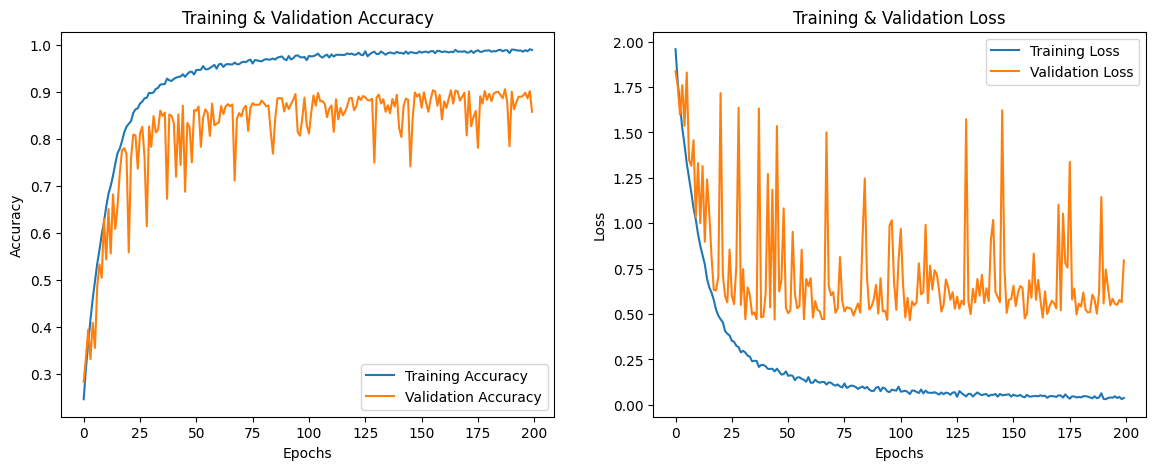

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.models import load_model

lstm_model = load_model("best_lstm_model.keras")

test_loss, test_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=1)
print(f"LSTM Test Loss: {test_loss}")
print(f"LSTM Test Accuracy: {test_accuracy}")


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9016 - loss: 0.4724
LSTM Test Loss: 0.526096522808075
LSTM Test Accuracy: 0.8958333134651184


In [ ]:
from tensorflow.keras.models import load_model

model.save('emotion_lstm_model.keras')
print("Model saved as emotion_lstm_model.keras")


Model saved as emotion_lstm_model.keras


-------
------
-----
------
------
---------
-------

# Nov, 2024

## 1- Using ResNet50

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)


GPU memory growth enabled.


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Dropout

def residual_block(input_tensor, filters, kernel_size=3):
    shortcut = input_tensor

    x = Conv1D(filters, kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding="same")(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x


input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)

x = Conv1D(64, kernel_size=3, activation='relu', padding="same")(inputs)
x = BatchNormalization()(x)

x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)

x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(Y_train.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 214, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 214, 64)        │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 214, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 214, 64)        │         12,352 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 214, 64)        │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 214, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 214, 64)        │         12,352 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 214, 64)        │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 214, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 214, 64)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 214, 128)       │         24,704 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 214, 128)       │            512 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 214, 128)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 214, 128)       │         49,280 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 214, 128)       │            512 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 214, 128)       │          8,320 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 507,400 (1.94 MB)

 Trainable params: 505,480 (1.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2490 - loss: 1.8974 - val_accuracy: 0.2424 - val_loss: 2.0128
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3481 - loss: 1.6809 - val_accuracy: 0.1727 - val_loss: 2.7578
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4094 - loss: 1.5478 - val_accuracy: 0.2956 - val_loss: 2.0069
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4450 - loss: 1.4595 - val_accuracy: 0.2194 - val_loss: 4.0942
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4700 - loss: 1.3900 - val_accuracy: 0.1838 - val_loss: 3.8773
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4868 - loss: 1.3488 - val_accuracy: 0.1506 - val_loss: 7.1841
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5157 - loss: 1.2788 - val_accuracy: 0.1719 - val_loss: 4.9165
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5245 - loss: 1.2432 - val_ac

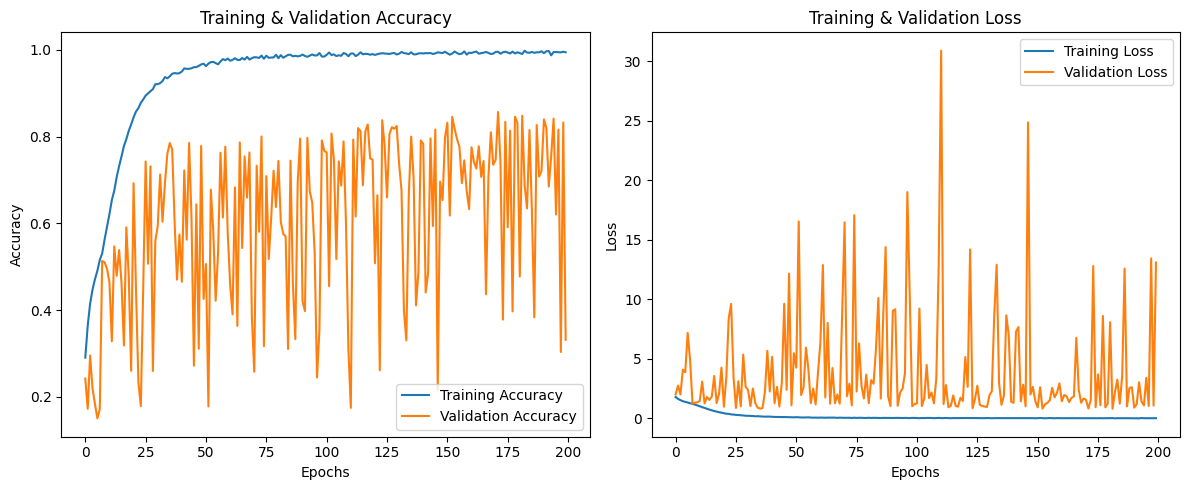

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 2- Add dropout

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

df = pd.read_csv('emotion_features.csv')

X = df.iloc[:, :-1].values
Y = df['Emotion'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Dropout

def residual_block(input_tensor, filters, kernel_size=3):
    shortcut = input_tensor

    x = Conv1D(filters, kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    x = Conv1D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding="same")(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    return x


input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)

x = Conv1D(64, kernel_size=3, activation='relu', padding="same")(inputs)
x = BatchNormalization()(x)

x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)

x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(Y_train.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 214, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 214, 64)        │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 214, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 214, 64)        │         12,352 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 214, 64)        │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 214, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 214, 64)        │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 214, 64)        │         12,352 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 214, 64)        │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 214, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 214, 64)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 214, 64)        │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 214, 128)       │         24,704 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 214, 128)       │            512 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 214, 128)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 214, 128)       │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 214, 128)       │         49,280 │ dropout_2[0][0]        │
├──────────────────────

 Total params: 507,400 (1.94 MB)

 Trainable params: 505,480 (1.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=200, batch_size=64, validation_data=(X_test, Y_test))


Epoch 1/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.2144 - loss: 1.9638 - val_accuracy: 0.2878 - val_loss: 1.7830
Epoch 2/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3163 - loss: 1.7540 - val_accuracy: 0.1519 - val_loss: 3.6437
Epoch 3/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3338 - loss: 1.7162 - val_accuracy: 0.2207 - val_loss: 2.4002
Epoch 4/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3527 - loss: 1.6714 - val_accuracy: 0.3431 - val_loss: 1.7726
Epoch 5/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3752 - loss: 1.6284 - val_accuracy: 0.2962 - val_loss: 2.0809
Epoch 6/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3874 - loss: 1.5951 - val_accuracy: 0.3533 - val_loss: 1.7189
Epoch 7/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4031 - loss: 1.5682 - val_accuracy: 0.3110 - val_loss: 1.9626
Epoch 8/200
288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4082 - loss: 1.5471 - val_ac

In [8]:
model.save('emotion_resnet_model.keras')
print("Model saved successfully.")


Model saved successfully.


In [9]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
print(f"ResNet Test Loss: {test_loss}")
print(f"ResNet Test Accuracy: {test_accuracy}")


144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8803 - loss: 0.3627
ResNet Test Loss: 0.34459853172302246
ResNet Test Accuracy: 0.88671875
